# Assignment 2: Itaconic acid production (part 2)

<img src="Ita_model.png" width="800" />

Firstly, import all the necessary libraries:

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import pandas as pd
%matplotlib notebook

Now specify constants and known values. Beta is determined. CO$_{2}$ mass transfer coefficient is determined.

In [4]:
alpha = 0.1
gamma = 2.5
mumax = 0.05
thetamax = 0.05
PO = 1.5

Km = 0.001

def beta(beta):
    nul1 = (1 + alpha)*4 - ((4 + 1*1.8 - 2*0.5 - 3*0.2) + 2*beta)
    return nul1
beta = fsolve(beta, alpha)[0]

tmax = 150
cS0 = 20
cX0 = 0.1

kLa = 200 # 1/h
cOsatmax = 7/1000/32  #mol/l
rOmt = kLa*cOsatmax

The metabolic flux matrix is set up.

In [5]:
Sflux = np.matrix([[-1,  1 + alpha, 1,      1,   0,    0,    0],
                   [0,   0,         0,      -1,  3/2,  1.2,  0],
                   [0,   beta,      2,      1/3, -1/2, 1/5,  -2],
                   [0,   -gamma,    1/2,    1/3, 0,    0,    2*PO]])
#                   rS,  rX,        r_resp, r3,  rEt,  rIta, rO
#                   r[0] r[1]       r[2]         r[4]  r[5]  r[6]
Et_spec = [0, 0, 0, 0, 1, 0, 0]
O_spec = [0, 0, 0, 0, 0, 0, 1]
resp_spec = [0, 0, 1, 0, 0, 0, 0]
Ita_spec = [0, 0, 0, 0, 0, 1, 0]
mu_spec = [0, 1, 0, 0, 0, 0, 0]
S_spec = [1, 0, 0, 0, 0, 0, 0]

Specifications are chosen for the scenarios we are working with.

In [6]:
S1 = np.vstack([Sflux, Et_spec, mu_spec, Ita_spec])
S2 = np.vstack([Sflux, Et_spec, mu_spec, O_spec])
S3 = np.vstack([Sflux, Et_spec, resp_spec, O_spec])

# C1 = np.array([0, 0, 0, theta, 0, mu, 0])
# C2 = np.array([0, 0, 0, theta, 0, mu, rOmt/cX])
# C3 = np.array([0, 0, 0, theta, 0, 0, rOmt/cX])
# r1 = np.linalg.solve(S1, C1)
# r2 = np.linalg.solve(S2, C2)
# r3 = np.linalg.solve(S3, C3)

The rate function is written.

In [7]:
def rate(var):
    cS, cX, cI = var
    
    mu = mumax*cS/(Km + cS)
    if mu < 0.00001:
        mu = 0
    theta = thetamax*cS/(Km + cS)
    
    C1 = np.array([0, 0, 0, theta, 0, mu, 0])
    r1 = np.linalg.solve(S1, C1)
    
    C2 = np.array([0, 0, 0, theta, 0, mu, rOmt/cX])
    r2 = np.linalg.solve(S2, C2)
    
    C3 = np.array([0, 0, 0, theta, 0, 0, rOmt/cX])
    r3 = np.linalg.solve(S3, C3)
    
    r = r1
    
    if rOmt < r1[6]*cX:
        r = r2
        if r2[2] < 0:
            r = r3
    return r

The fermenter function is written.

In [8]:
def batch(var, t):
    cS, cX, cI = var
    dcSdt = -rate(var)[0]*cX
    dcXdt = rate(var)[1]*cX
    dcIdt = rate(var)[5]*cX
    return dcSdt, dcXdt, dcIdt

The fermenter function is integrated and gas/liquid metaboite rates are determined.

In [9]:
tspan = np.linspace(0, 150, 1000)

cS0 = 20
cX0 = 0.1
cI0 = 0
ci0 = [cS0, cX0, cI0]

ci = odeint(batch, ci0, tspan)
cS, cX, cI = ci.T

ri = np.asarray([rate([cSi, cXi, cIi]) for [cSi, cXi, cIi] in ci])
rS = ri[:, 0]
rX = ri[:, 1]
r_resp = ri[:, 2]
rI = ri[:, 5]
rO = ri[:, 6]
rC = alpha*ri[:, 1] + ri[:, 2] + 1/2*ri[:, 4] + 1/5*ri[:, 5]

rATP = -gamma*ri[:, 1] + 1/2*ri[:, 2] + 1/3*ri[:, 3] + 2*PO*ri[:, 6]

Concentration profiles are plotted.

<IPython.core.display.Javascript object>


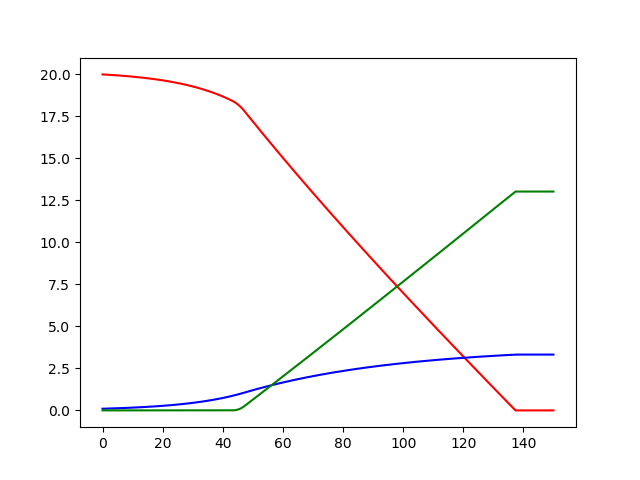

In [10]:
plt.figure(1)
plt.plot(tspan, cS, 'r')
plt.plot(tspan, cX, 'b')
plt.plot(tspan, cI, 'g')

Biomass formation rate, $\mu$, is plotted.

<IPython.core.display.Javascript object>


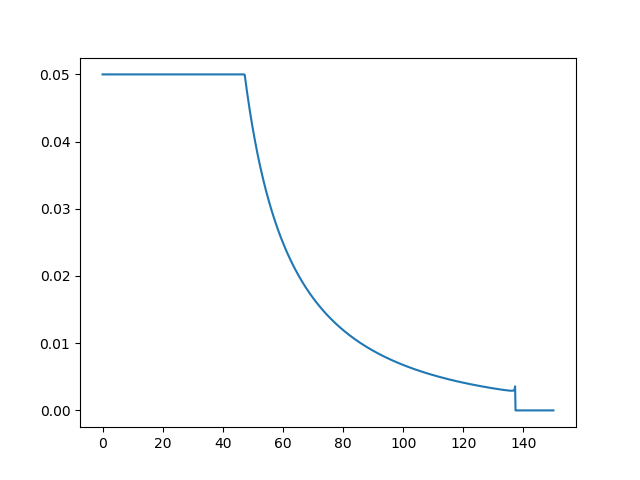

In [11]:
plt.figure(2)
plt.plot(tspan, rX)
plt.show()

<IPython.core.display.Javascript object>


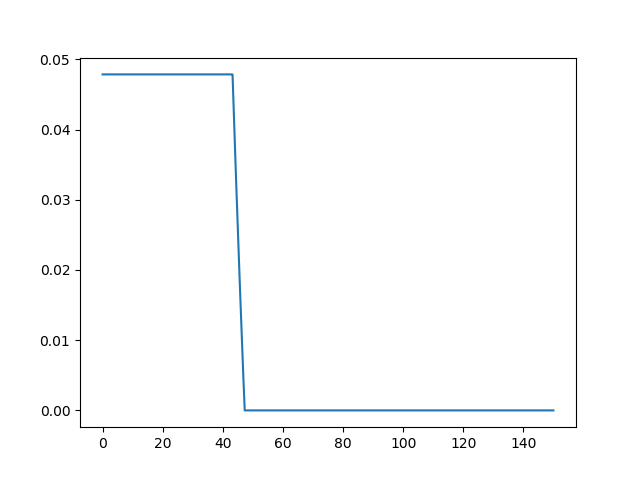

In [12]:
plt.figure(3)
plt.plot(tspan, r_resp)
plt.show()

<IPython.core.display.Javascript object>


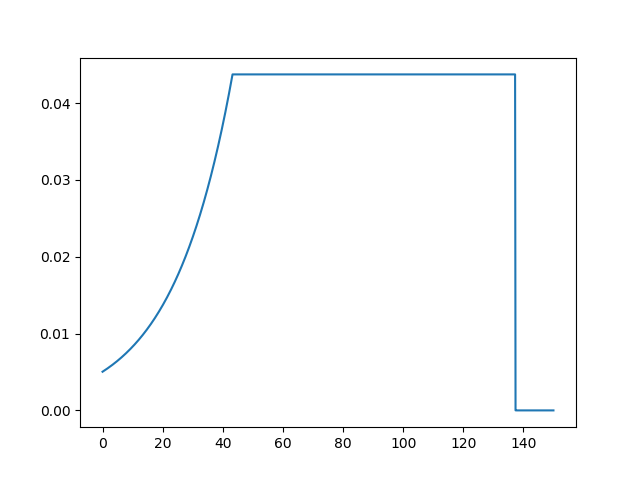

In [13]:
plt.figure(4)
plt.plot(tspan, rO*cX)
plt.show()

<IPython.core.display.Javascript object>


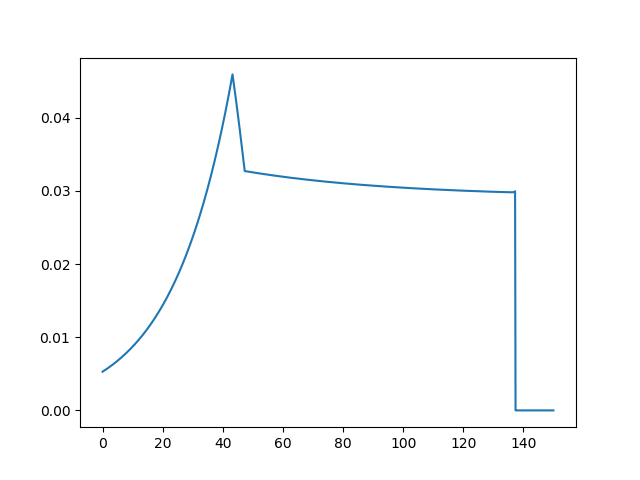

In [14]:
plt.figure(5)
plt.plot(tspan, rC*cX)
plt.show()

<IPython.core.display.Javascript object>


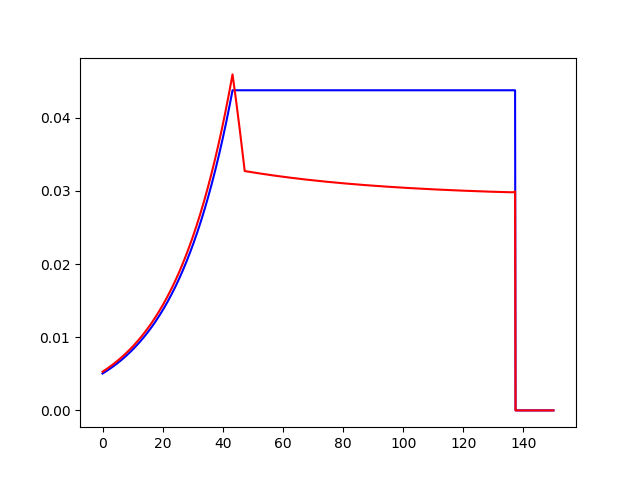

In [15]:
plt.figure(6)
plt.plot(tspan, rO*cX, 'b')
plt.plot(tspan, rC*cX, 'r')
plt.show()

From the plot above, the three different carbon dioxide regimes are clear, whereas only two oxygen regimes are present. This is in accordance with the conditions specified in the flux model.

In [16]:
YOATP = rATP/rO

<IPython.core.display.Javascript object>


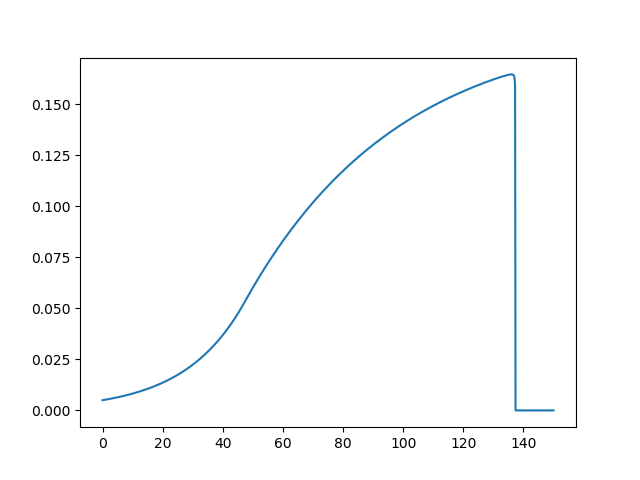

In [17]:
plt.figure(7)
plt.plot(tspan, rATP*cX)
plt.show()

<IPython.core.display.Javascript object>


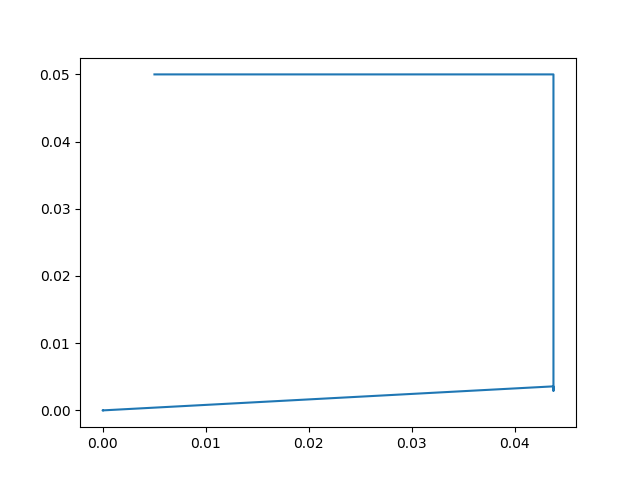

In [18]:
plt.figure(8)
plt.plot(rO*cX, rX)
plt.show()

<IPython.core.display.Javascript object>


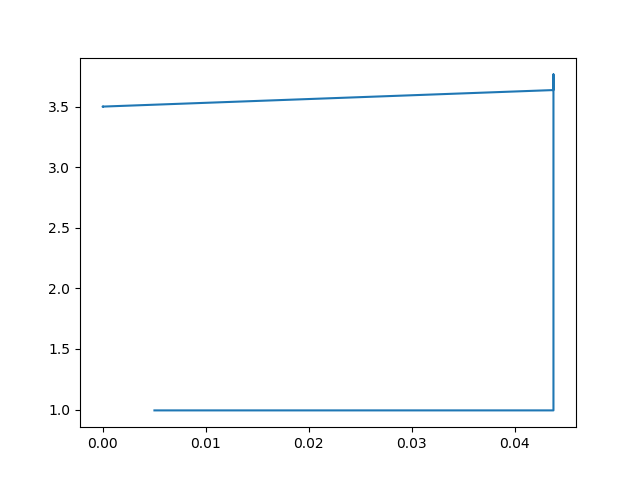

In [19]:
plt.figure(9)
plt.plot(rO*cX, YOATP)
plt.show()